# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.02556023, -0.18149665, -0.04241421,  0.2982546 ]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.3740928081266124 -3.008733911813324


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [8]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [10]:
# Policy learning: past/taken action
# Adverserial/reward learning: current reward optimization
# Q learning: future rewards optimization
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                     labels=tf.reshape(rewards2[1:], shape=[-1, 1])))
    
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                    labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                     labels=tf.reshape(rewards3[1:], shape=[-1, 1])))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss

In [11]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [14]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
env.reset()

array([ 0.04887464, -0.0381064 ,  0.03707945, -0.04832743])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
state, reward, action

(array([-0.14214085, -1.40894957,  0.22639983,  2.28680681]), 1.0, 0)

In [37]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            action *= 1 - float(done) # last action is always 0
            batch.append([state, action])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states,
                                                                     model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 Total reward: 9.0 Batch loss: 0.567416966
Episode: 1 Total reward: 10.0 Batch loss: 0.515183270
Episode: 2 Total reward: 8.0 Batch loss: 0.498703748
Episode: 3 Total reward: 10.0 Batch loss: 0.418120682
Episode: 4 Total reward: 10.0 Batch loss: 0.390012383
Episode: 5 Total reward: 9.0 Batch loss: 0.374738306
Episode: 6 Total reward: 9.0 Batch loss: 0.349416941
Episode: 7 Total reward: 10.0 Batch loss: 0.291199446
Episode: 8 Total reward: 10.0 Batch loss: 0.277127773
Episode: 9 Total reward: 10.0 Batch loss: 0.255641639
Episode: 10 Total reward: 9.0 Batch loss: 0.263052493
Episode: 11 Total reward: 10.0 Batch loss: 0.220319822
Episode: 12 Total reward: 10.0 Batch loss: 0.206368014
Episode: 13 Total reward: 10.0 Batch loss: 0.203397393
Episode: 14 Total reward: 9.0 Batch loss: 0.197131753
Episode: 15 Total reward: 9.0 Batch loss: 0.183314264
Episode: 16 Total reward: 10.0 Batch loss: 0.157969594
Episode: 17 Total reward: 8.0 Batch loss: 0.182757333
Episode: 18 Total reward: 9.

Episode: 169 Total reward: 10.0 Batch loss: 0.000474918
Episode: 170 Total reward: 9.0 Batch loss: 0.000679031
Episode: 171 Total reward: 10.0 Batch loss: 0.000623698
Episode: 172 Total reward: 9.0 Batch loss: 0.000497819
Episode: 173 Total reward: 9.0 Batch loss: 0.000491232
Episode: 174 Total reward: 8.0 Batch loss: 0.000631823
Episode: 175 Total reward: 9.0 Batch loss: 0.000691231
Episode: 176 Total reward: 8.0 Batch loss: 0.000608272
Episode: 177 Total reward: 9.0 Batch loss: 0.000590392
Episode: 178 Total reward: 9.0 Batch loss: 0.000694490
Episode: 179 Total reward: 9.0 Batch loss: 0.000568822
Episode: 180 Total reward: 10.0 Batch loss: 0.000578249
Episode: 181 Total reward: 10.0 Batch loss: 0.000546839
Episode: 182 Total reward: 9.0 Batch loss: 0.000525601
Episode: 183 Total reward: 10.0 Batch loss: 0.000655155
Episode: 184 Total reward: 10.0 Batch loss: 0.000514673
Episode: 185 Total reward: 9.0 Batch loss: 0.000411186
Episode: 186 Total reward: 10.0 Batch loss: 0.000539078
Epi

Episode: 336 Total reward: 10.0 Batch loss: 0.000108918
Episode: 337 Total reward: 8.0 Batch loss: 0.000128194
Episode: 338 Total reward: 10.0 Batch loss: 0.000088558
Episode: 339 Total reward: 10.0 Batch loss: 0.000134502
Episode: 340 Total reward: 9.0 Batch loss: 0.000147302
Episode: 341 Total reward: 10.0 Batch loss: 0.000163597
Episode: 342 Total reward: 9.0 Batch loss: 0.000115777
Episode: 343 Total reward: 10.0 Batch loss: 0.000102521
Episode: 344 Total reward: 9.0 Batch loss: 0.000110482
Episode: 345 Total reward: 9.0 Batch loss: 0.000172735
Episode: 346 Total reward: 10.0 Batch loss: 0.000154904
Episode: 347 Total reward: 8.0 Batch loss: 0.000170791
Episode: 348 Total reward: 10.0 Batch loss: 0.000146401
Episode: 349 Total reward: 10.0 Batch loss: 0.000135407
Episode: 350 Total reward: 10.0 Batch loss: 0.000140696
Episode: 351 Total reward: 10.0 Batch loss: 0.000096421
Episode: 352 Total reward: 9.0 Batch loss: 0.000130601
Episode: 353 Total reward: 9.0 Batch loss: 0.000101204


Episode: 503 Total reward: 11.0 Batch loss: 0.000051597
Episode: 504 Total reward: 9.0 Batch loss: 0.000055661
Episode: 505 Total reward: 11.0 Batch loss: 0.000048423
Episode: 506 Total reward: 8.0 Batch loss: 0.000043059
Episode: 507 Total reward: 10.0 Batch loss: 0.000060379
Episode: 508 Total reward: 9.0 Batch loss: 0.000042274
Episode: 509 Total reward: 9.0 Batch loss: 0.000046087
Episode: 510 Total reward: 9.0 Batch loss: 0.000056018
Episode: 511 Total reward: 8.0 Batch loss: 0.000057420
Episode: 512 Total reward: 10.0 Batch loss: 0.000051239
Episode: 513 Total reward: 8.0 Batch loss: 0.000061531
Episode: 514 Total reward: 9.0 Batch loss: 0.000058269
Episode: 515 Total reward: 8.0 Batch loss: 0.000058447
Episode: 516 Total reward: 10.0 Batch loss: 0.000049404
Episode: 517 Total reward: 9.0 Batch loss: 0.000051132
Episode: 518 Total reward: 10.0 Batch loss: 0.000043255
Episode: 519 Total reward: 8.0 Batch loss: 0.000069098
Episode: 520 Total reward: 9.0 Batch loss: 0.000065273
Epis

Episode: 677 Total reward: 9.0 Batch loss: 0.000034050
Episode: 678 Total reward: 9.0 Batch loss: 0.000030038
Episode: 679 Total reward: 8.0 Batch loss: 0.000029114
Episode: 680 Total reward: 10.0 Batch loss: 0.000030359
Episode: 681 Total reward: 9.0 Batch loss: 0.000032779
Episode: 682 Total reward: 10.0 Batch loss: 0.000028238
Episode: 683 Total reward: 9.0 Batch loss: 0.000033137
Episode: 684 Total reward: 8.0 Batch loss: 0.000037308
Episode: 685 Total reward: 10.0 Batch loss: 0.000029906
Episode: 686 Total reward: 9.0 Batch loss: 0.000024052
Episode: 687 Total reward: 9.0 Batch loss: 0.000035706
Episode: 688 Total reward: 8.0 Batch loss: 0.000032928
Episode: 689 Total reward: 10.0 Batch loss: 0.000023053
Episode: 690 Total reward: 9.0 Batch loss: 0.000035163
Episode: 691 Total reward: 10.0 Batch loss: 0.000022886
Episode: 692 Total reward: 10.0 Batch loss: 0.000033530
Episode: 693 Total reward: 9.0 Batch loss: 0.000033031
Episode: 694 Total reward: 10.0 Batch loss: 0.000017606
Epi

Episode: 825 Total reward: 10.0 Batch loss: 0.000014519
Episode: 826 Total reward: 8.0 Batch loss: 0.000019028
Episode: 827 Total reward: 9.0 Batch loss: 0.000015854
Episode: 828 Total reward: 9.0 Batch loss: 0.000014238
Episode: 829 Total reward: 10.0 Batch loss: 0.000014710
Episode: 830 Total reward: 11.0 Batch loss: 0.000018736
Episode: 831 Total reward: 10.0 Batch loss: 0.000016450
Episode: 832 Total reward: 10.0 Batch loss: 0.000015472
Episode: 833 Total reward: 10.0 Batch loss: 0.000014054
Episode: 834 Total reward: 9.0 Batch loss: 0.000021655
Episode: 835 Total reward: 9.0 Batch loss: 0.000016251
Episode: 836 Total reward: 8.0 Batch loss: 0.000018223
Episode: 837 Total reward: 8.0 Batch loss: 0.000021024
Episode: 838 Total reward: 10.0 Batch loss: 0.000018238
Episode: 839 Total reward: 10.0 Batch loss: 0.000021146
Episode: 840 Total reward: 8.0 Batch loss: 0.000018178
Episode: 841 Total reward: 10.0 Batch loss: 0.000019060
Episode: 842 Total reward: 10.0 Batch loss: 0.000016366


Episode: 992 Total reward: 10.0 Batch loss: 0.000009095
Episode: 993 Total reward: 10.0 Batch loss: 0.000009858
Episode: 994 Total reward: 9.0 Batch loss: 0.000008411
Episode: 995 Total reward: 9.0 Batch loss: 0.000018119
Episode: 996 Total reward: 10.0 Batch loss: 0.000012516
Episode: 997 Total reward: 9.0 Batch loss: 0.000011828
Episode: 998 Total reward: 10.0 Batch loss: 0.000009894
Episode: 999 Total reward: 10.0 Batch loss: 0.000011801


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

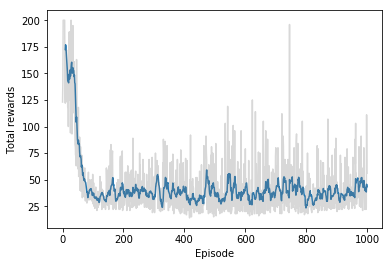

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

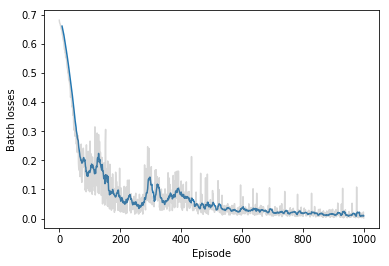

In [28]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [77]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

# Now train with experiences
saver = tf.train.Saver()

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.

In [80]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [81]:
# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 100
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
        g_loss, d_loss, _ = sess.run([model.g_loss, model.d_loss, model.d_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        gloss_list.append([ep, g_loss])
        dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pqn.ckpt')

Text(0,0.5,'Total env rewards')

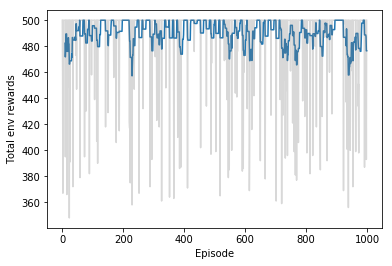

In [78]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

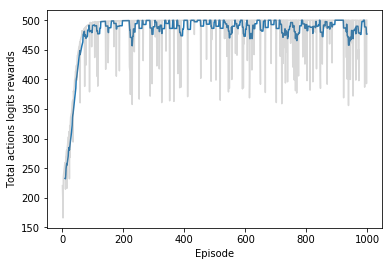

In [83]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

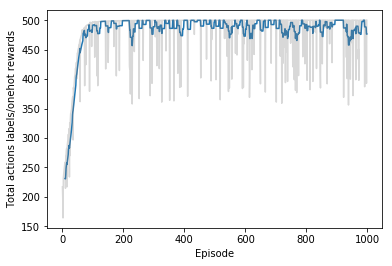

In [84]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Batch loss')

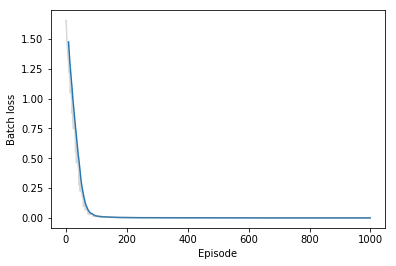

In [81]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch loss')